# Visualize feature extract result

把NN內的結果output出來看  
其中CNN的結果是最容易觀察與查看結果的  
查看結果可以幫助理解CNN工作原理  
與幫助判讀結果是否合乎預期  

利用先前設立的dog vs cat 資料集
與VGG16  

In [1]:
from keras.applications import VGG16

model_vgg = VGG16(weights ='imagenet', include_top=False, input_shape=(150,150,3))
model_vgg.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
bloc

## Part1. 可視化激勵結果

利用中間層的輸出來看看電腦"看"到什麼

#### Step1. 導入圖片

畫圖利用matplotlib，因此把圖檔轉換成numpy形式，並且調整維度到符合神經元輸入

(1, 150, 150, 3)


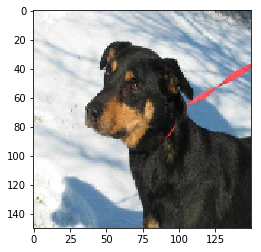

In [3]:
import os
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt

data_path = os.getcwd()+'/dogs-vs-cats/train/dog.5000.jpg'

img = image.load_img(data_path,target_size = (150,150))
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)/255


print(img.shape)

plt.figure()
plt.imshow(img[0])

#### Step2. 建立輸出

另外設置一組output來看看VGG16的輸出

In [4]:
from keras import models

#out_put= [layers.output for layers in model_vgg.layers[0:8]]

out_put = [model_vgg.get_layer('block1_conv2').output,
           model_vgg.get_layer('block2_conv2').output,
           model_vgg.get_layer('block3_conv2').output,
           model_vgg.get_layer('block4_conv2').output,]

activate_model = models.Model(inputs = model_vgg.input, outputs = out_put )

利用這個模型來把剛剛處理過的圖像丟入

In [5]:
result_act = activate_model.predict(img)

查看一下內容

隨意檢查其中一組output的其中一組通道

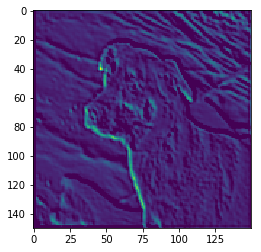

In [6]:
plt.figure()
plt.imshow(result_act[0][0,:,:,5])

這看起來像是抓取邊框

#### Step3. 把所有內容通道都印出來看看

C:\Users\a2720\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


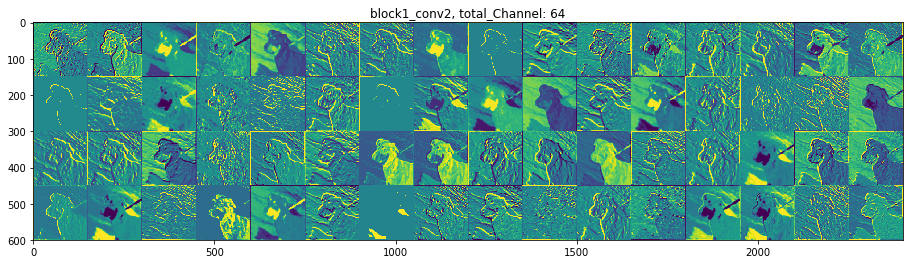

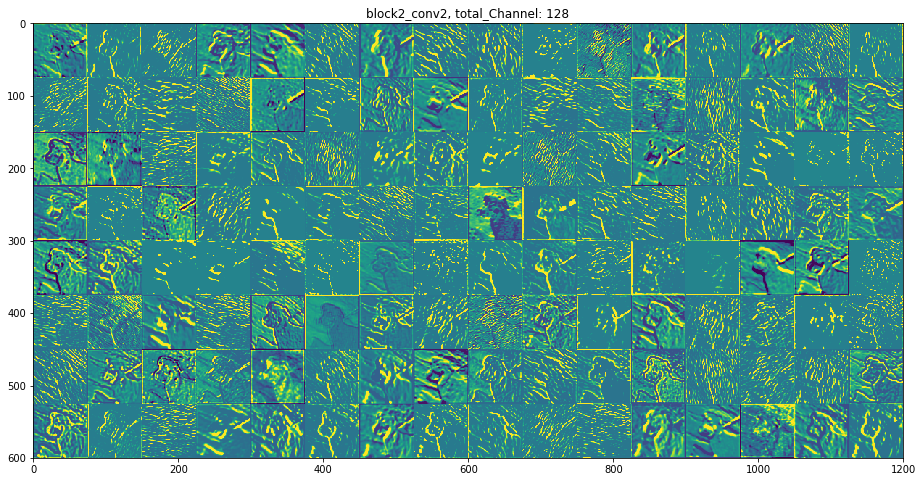

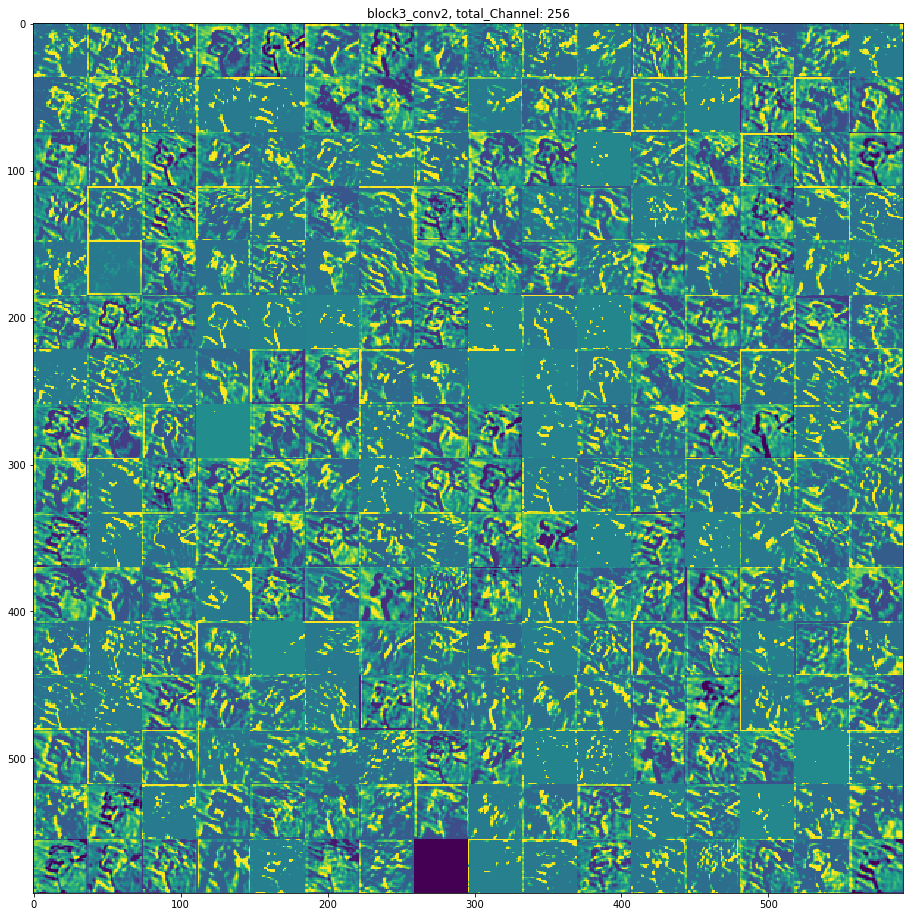

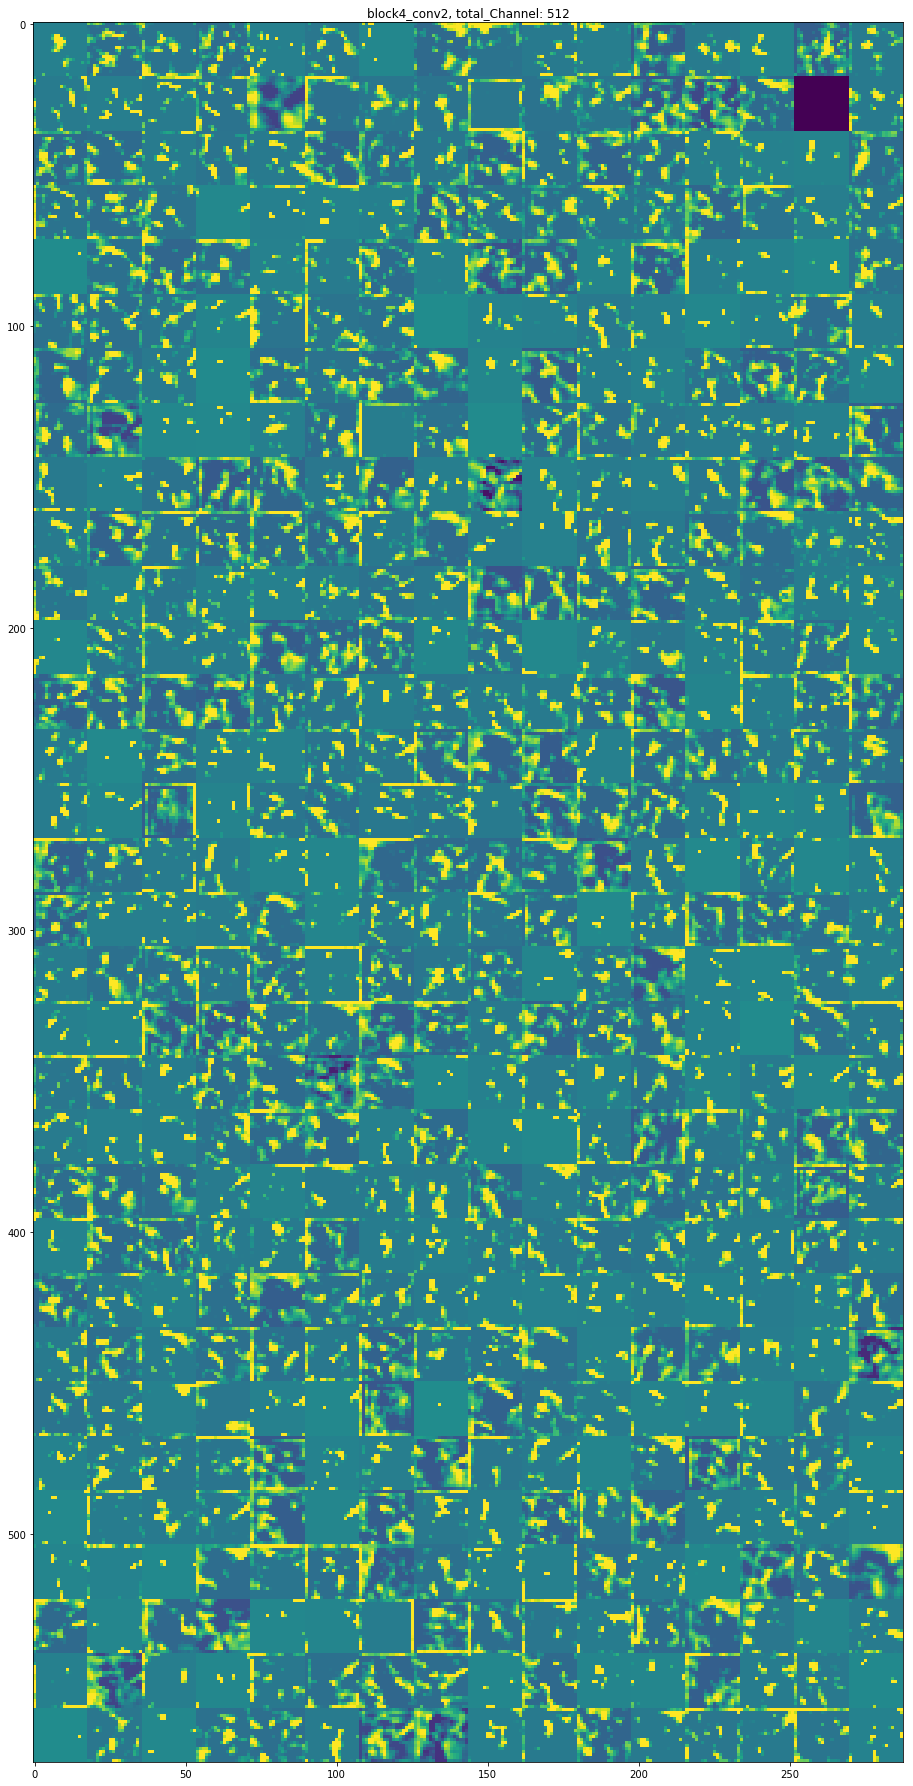

In [7]:
layer_names = ['block1_conv2','block2_conv2','block3_conv2','block4_conv2']

img_per_row = 16

for layer_name , img in zip(layer_names, result_act):
    
    number_image = img.shape[-1]
    size = img.shape[1]
    total_row = number_image // img_per_row
    display_img = np.zeros((size*total_row,size*img_per_row))
    
    
    for i in range(number_image):
        channel_img = img[0,:,:,i]
        channel_img -= channel_img.mean()
        channel_img /= channel_img.std()
        channel_img *= 64
        channel_img += 128
        channel_img = np.clip(channel_img, 0, 255).astype('uint8')
        
        row = int(i/img_per_row)
        col = int(i%img_per_row)
        display_img[row*size:(row+1)*size,col*size:(col+1)*size] = channel_img
    
    scale=1./size
    plt.figure(figsize=(display_img.shape[1]*scale,display_img.shape[0]*scale))
    plt.imshow(display_img ,  cmap='viridis')
    plt.title(layer_name+', total_Channel: '+ str(number_image))

plt.show()
    

更後面的卷積層所認知的越抽象，其中空白的部分代表該神經元對圖形沒有激勵(認知)  
亮的部分代表著該神經元對於圖像的反應部分  
後面可以利用這個來產生熱力圖

## Part 2. 卷積過濾器視覺化

通過自訂損失函數與輸入一張圖片讓每個神經元做gradian ascend來看看該神經元對什麼樣的圖形最敏感  
其代表意義可看作是該神經元負責過濾什麼樣的圖形

一樣利用VGG16來做
一個視覺化圖形需要經過:
* 損失函數: 利用keras backend來定義一組損失函數
* 梯度爬升: 利用keras backend的Gradiant來獲得梯度  

來獲得我們想要的結果

In [8]:
def process(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    x += 0.5
    x = np.clip(x, 0, 1)

    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [9]:
from keras import backend as K
def generate_img(layer,filter):
    output = model_vgg.get_layer(layer).output 
    
    loss = K.mean(output[:,:,:,filter])
    gradiant = K.gradients(loss, model_vgg.input)[0]  #output a tensor
    gradiant /= (K.sqrt(K.mean(K.square(gradiant))) + 1e-5)
    
    iterate = K.function([model_vgg.input], [loss, gradiant])
    
    initial_img = np.random.rand(1,150,150,3)
    
    arpha=1.
    for i in range(30):
        loss , grad = iterate([initial_img])
        initial_img += grad*arpha
        
    return initial_img[0]

測試結果

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


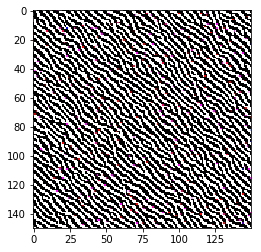

In [10]:
plt.imshow(generate_img('block1_conv2',30))

各層的output都印出來看看結果

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


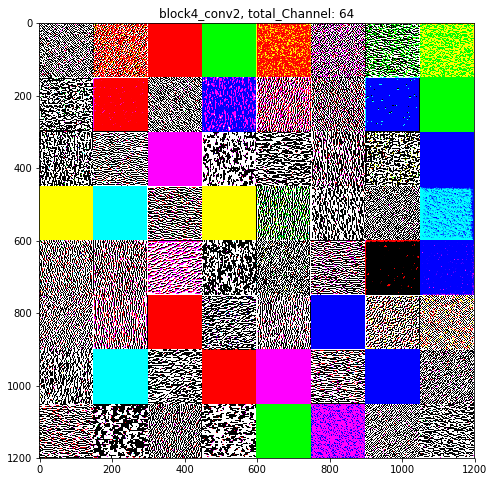

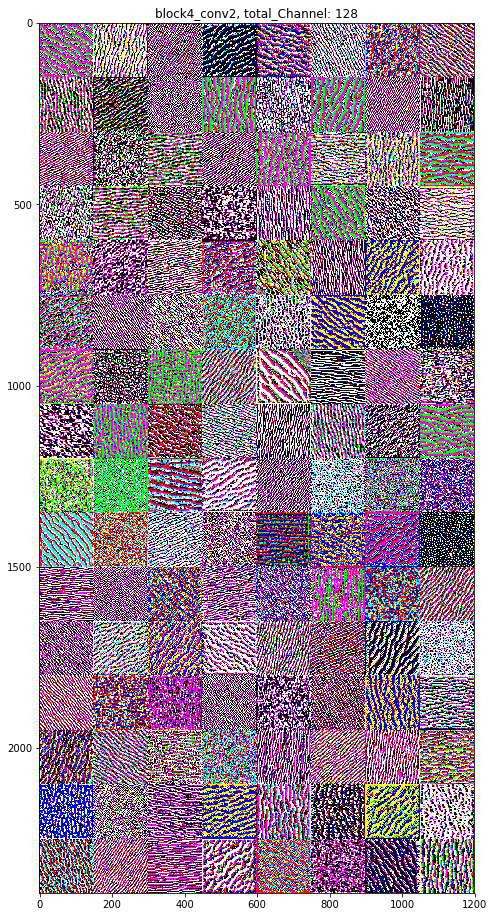

In [11]:
layer_names = ['block1_conv2','block2_conv2']
img_per_row =8

for layer in layer_names:
    output = model_vgg.get_layer(layer).output
    
    number_image = int(output.shape[-1])
    size = 150
    total_row = number_image // img_per_row
    display_img = np.zeros((size*total_row,size*img_per_row,3))
    
    
    for i in range(number_image):    
        row = int(i/img_per_row)
        col = int(i%img_per_row)
        display_img[row*size:(row+1)*size,col*size:(col+1)*size,:] = generate_img(layer,i)
    
    scale=1./size
    plt.figure(figsize=(display_img.shape[1]*scale,display_img.shape[0]*scale))
    plt.imshow(display_img)
    plt.title(layer_name+', total_Channel: '+ str(number_image))

plt.show()

## Part 3. 熱力圖

利用最後一層的卷積輸出與分類層的結果算出權重後  
把激勵的結果疊合到原圖上來看模型對於圖片的識別區域  


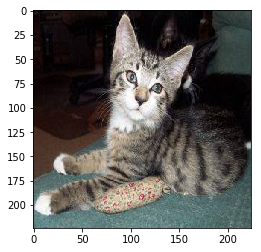

(1, 224, 224, 3)


In [12]:
from keras.applications.vgg16 import decode_predictions , preprocess_input

model = VGG16(weights='imagenet')

data_path= os.getcwd()+'/dogs-vs-cats/train/cat.186.jpg'
imgs = image.load_img(data_path,target_size = (224,224,3))
imgs = image.img_to_array(imgs)
plt.imshow(imgs/255)
plt.show()

imgs = np.expand_dims(imgs, axis = 0)
print(imgs.shape)


把這張圖丟入VGG16看看結果為何

In [13]:
import pandas as pd

result = model.predict(imgs)
res=np.array(decode_predictions(result,top=5))
print('Predicted:', res)

pd.DataFrame(res[0][:,2],index=res[0][:,1],columns=['probability'])

Predicted: [[['n02124075' 'Egyptian_cat' '0.94027257']
  ['n02123045' 'tabby' '0.04548281']
  ['n02123159' 'tiger_cat' '0.013845544']
  ['n02127052' 'lynx' '0.00033725286']
  ['n03887697' 'paper_towel' '6.130545e-06']]]


,probability
Egyptian_cat,0.94027257
tabby,0.04548281
tiger_cat,0.013845544
lynx,0.00033725286
paper_towel,6.130545e-06


最高的機率是埃及貓，判斷是埃及貓的機率有94%  

看看這在VGG是分類在哪一類

In [14]:
print(result.shape) 

np.argmax(result[0]) 

(1, 1000)


285

建立一個熱力圖基底  
其概念為利用最後一層卷基層的輸出對打算要判斷的埃及貓做梯度運算  
其梯度大小意義為該神經元對最終結果的'權重'  
在把這個權重乘上該神經元做加權平均後，所得到的就是熱力圖  

In [15]:
Egyptian_cat = model.output[:, 285]  # this get cat output probalility --- 1  return tensor
last_conv_layer = model.get_layer('block5_conv3')  # setting last covolution output --- 2  return tensor (?, 14, 14, 512)

grads = K.gradients(Egyptian_cat, last_conv_layer.output)[0]  # calculate 1&2 gradiant and return a tensor (?, 14, 14, 512)
pooled_grads = K.mean(grads, axis=(0, 1, 2))  # get the 'weight' of each neuron return tensro (512,)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([imgs])
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i] # this for stimulate the perceptive result


heatmap = np.mean(conv_layer_output_value, axis=-1)  

對熱力圖做處理讓其可以畫出來

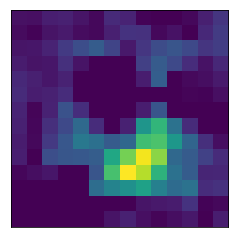

(14, 14)

In [16]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.imshow(heatmap)
plt.xticks([])
plt.yticks([])
plt.show() 

heatmap.shape 

把熱力圖重新調整

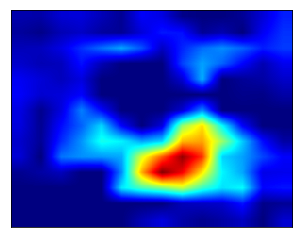

In [17]:
import cv2 as cv

img = cv.imread(data_path)
heatmap = cv.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv.applyColorMap(heatmap, cv.COLORMAP_JET)

heatmapshow = cv.cvtColor(heatmap,cv.COLOR_BGR2RGB)

plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(heatmapshow)

疊加上埃及貓的圖

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


([], <a list of 0 Text yticklabel objects>)

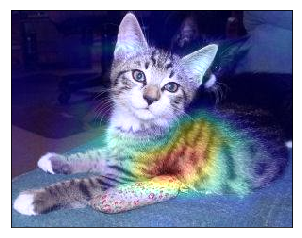

In [23]:
img= cv.cvtColor(img,cv.COLOR_BGR2RGB)
superimposed_img = heatmapshow * 0.3 + img

plt.imshow(superimposed_img/255)
plt.xticks([])
plt.yticks([])

可以看到NN對於埃及貓的觸發點是耳朵與身上的花紋  
利用熱力圖可以幫助查看神經網路的學習結果  
避免產生錯誤的認知  